In [94]:

import numpy as np
import torch
from torchvision.models import resnet50
from torch import nn
from torch.utils.data import DataLoader

from sklearn.metrics.pairwise import cosine_similarity

In [95]:
from scipy.spatial.distance import cdist
import numpy as np

# Example vectors (rows in a matrix)
vectors = np.array([
    [1, 2, 3],
    [4, 5, 6],
    [7, 8, 9]
])

# Compute pairwise Euclidean distances
distances = cdist(vectors, vectors, 'euclidean')

print(distances)


[[ 0.          5.19615242 10.39230485]
 [ 5.19615242  0.          5.19615242]
 [10.39230485  5.19615242  0.        ]]


In [96]:
# test_dataset = torch.load("data/test_dataset.pt")
test_pairs = np.load("test_data.npy")
test_labels = np.load("test_labels.npy")

from openset_ds import OpenSet

open_dataset = OpenSet(test_pairs, test_labels)

In [97]:
import os

baseline = resnet50(pretrained=True)
    
baseline.fc = nn.Linear(2048, 910)
    
if os.path.exists(f"models/baseline.pt"):
    baseline.load_state_dict(torch.load(f"models/baseline.pt"))

baseline.fc = torch.nn.Identity()

c:\Users\sebas\miniconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\sebas\miniconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [98]:
from torchvision import models

triplet = models.squeezenet1_1(pretrained=True)
    

bs = 128

# triplet.classifier = torch.nn.Identity()
# if os.path.exists(f"models/squeezenet_{bs}.pt"):
#     triplet.load_state_dict(torch.load(f"models/squeezenet_{bs}.pt"))
# if os.path.exists(f"models/sqnet.pt_18_"):
#     triplet.load_state_dict(torch.load(f"models/sqnet.pt_18_"))

n_classes = 910
triplet.classifier[1] = torch.nn.Conv2d(512, n_classes, kernel_size=(1, 1))
triplet.classifier = torch.nn.Identity()
if os.path.exists(f"models/sqbet.pt"):
    triplet.load_state_dict(torch.load(f"models/sqnet.pt"))

c:\Users\sebas\miniconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SqueezeNet1_1_Weights.IMAGENET1K_V1`. You can also use `weights=SqueezeNet1_1_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [99]:
def get_accuracy(embeddings, targets):
    embeddings = np.array(embeddings)
    targets = np.array(targets)
    
    # Get cosine similarity for all embeddings
    similarity_matrix = cosine_similarity(embeddings)
    
    # Fill diagonal with inf
    np.fill_diagonal(similarity_matrix, -np.inf)
    
    # Find the index of max sim for each embedding
    most_similar_indices = np.argmax(similarity_matrix, axis=1)
    
    # Extract the labels of the most similar items
    predicted_labels = [targets[i] for i in most_similar_indices]
    n_correct = sum(1 for true, pred in zip(targets, predicted_labels) if true == pred)
    
    accuracy = 100 * (n_correct / len(embeddings))
    
    return accuracy, predicted_labels

In [100]:
def get_embeddings(model, dataloader, device):
    embeddings = []
    targets = []
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            data = inputs.to(device)
            label = labels.to(device)
            batch_emb, batch_lab = [], []            
            
            emb = model(data)
            
            batch_emb.extend(emb.cpu())
            batch_lab.extend(label.cpu().tolist())
            
            embeddings.extend(batch_emb)
            targets.extend(batch_lab)
            
    return embeddings, targets

In [101]:
true_pairs, fake_pairs = [], []

In [102]:

def get_embeddings_accuracy(model, dataloader, device, baseline=False):
    global true_pairs, fake_pairs
    true_pairs, fake_pairs = [], []
    n_correct = 0
    
    tp, fp, tn, fn = 0, 0, 0, 0
    
    thresh = .725
    thresh = 0.7611905932426453 # Calculated from train data
    if baseline:
        thresh = .5
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            img1, img2 = inputs[:, 0], inputs[:, 1]
            img1, img2 = img1.to(device), img2.to(device)
            
            lab1, lab2 = labels[:, 0], labels[:, 1]
            
            emb1 = model(img1).cpu()
            emb2 = model(img2).cpu()
            
            sim = cosine_similarity(emb1, emb2)
            
            for i in range(len(sim)):            
                if lab1[i] == lab2[i]:
                    true_pairs.append(sim[i][i])
                else:
                    fake_pairs.append(sim[i][i])
                res = sim[i][i]
                
                if res > thresh and lab1[i] == lab2[i]:
                    n_correct += 1
                    tp += 1
                if res < thresh and lab1[i] != lab2[i]:
                    n_correct += 1
                    tn += 1
                if res < thresh and lab1[i] == lab2[i]:
                    fn += 1
                if res > thresh and lab1[i] != lab2[i]:
                    fp += 1
                    
    return n_correct, (tp, tn, fp, fn)

In [103]:
test_dataloader = DataLoader(open_dataset, 128, True)

In [104]:
device = "cuda"


In [105]:
baseline = baseline.to(device)

# baseline_emb, baseline_targ = get_embeddings(baseline, test_dataloader, "cuda")
# baseline_emb, baseline_targ = 
n_correct, (tp, tn, fp, fn)  = get_embeddings_accuracy(baseline, test_dataloader, "cuda", baseline=True)
print(n_correct)

38491


In [106]:
n_correct / (len(test_dataloader) * bs)

0.5088171531302876

In [107]:
acc = (tp + tn) / (tp + tn + fp + fn)
recall = (tp) / (tp + fn)
precision = (tp) / (tp + fp)
f1 = (tp) / (tp + (fp + fn) / 2)

In [108]:
print(acc, recall, precision, f1)

0.5093018947814121 0.037739322533136964 0.7431382703262558 0.07183080966086848


In [109]:
n_correct / len(open_dataset)

0.5093018947814121

In [110]:
# for i in range(len(baseline_emb)):
#     baseline_emb[i] = baseline_emb[i].detach().numpy()

In [111]:
# type(baseline_emb[0])

In [112]:
# baseline_accuracy, baseline_preds = get_accuracy(baseline_emb, baseline_targ)

In [113]:
# baseline_accuracy

In [114]:
len(true_pairs), len(fake_pairs)

(38024, 37552)

In [115]:
np.mean(true_pairs), np.mean(fake_pairs)

(0.3856035, 0.37055176)

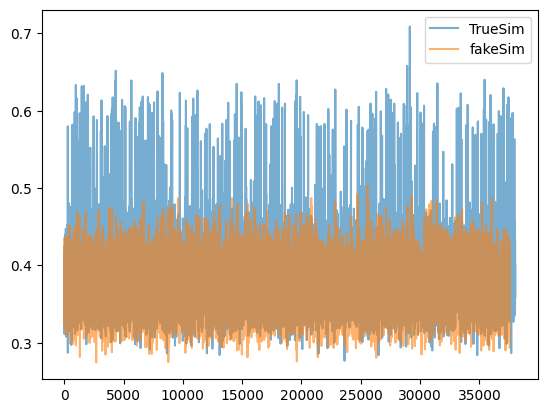

In [116]:
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

plt.plot(gaussian_filter(true_pairs, sigma=1), label="TrueSim", alpha=.6)
plt.plot(gaussian_filter(fake_pairs, sigma=1), label="fakeSim", alpha=.6)
plt.legend()

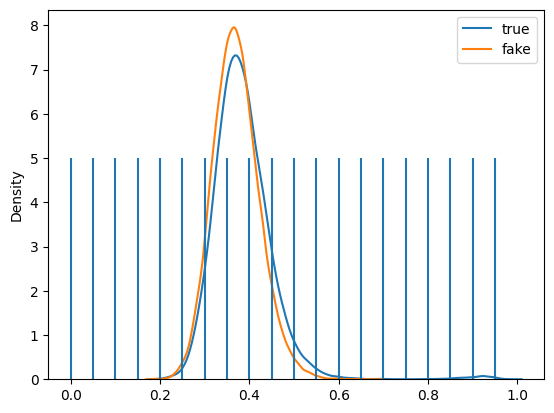

In [117]:
import cv2
import seaborn as sns

sns.kdeplot(true_pairs, label="true")
sns.kdeplot(fake_pairs, label="fake")
plt.legend()
plt.vlines([0.05 * i for i in range(20)], ymin=0, ymax=5)
# plt.plot(true_pairs)
# plt.plot(fake_pairs)

In [118]:
triplet = triplet.to(device)
# triplet_emb, triplet_targ = get_embeddings(triplet, test_dataloader, "cuda")
n_correct, (tp, tn, fp, fn) = get_embeddings_accuracy(triplet, test_dataloader, "cuda")
print(n_correct / len(open_dataset))
# for i in range(len(triplet_emb)):
#     triplet_emb[i] = triplet_emb[i].detach().numpy()

# triplet_accuracy, triplet_preds = get_accuracy(triplet_emb, triplet_targ)

0.5479517307081613


In [119]:
acc = (tp + tn) / (tp + tn + fp + fn)
recall = (tp) / (tp + fn)
precision = (tp) / (tp + fp)
f1 = (tp) / (tp + (fp + fn) / 2)

In [120]:
print(acc, recall, precision, f1)

0.5479517307081613 0.27816642120765833 0.6115993986353648 0.38240717307205613


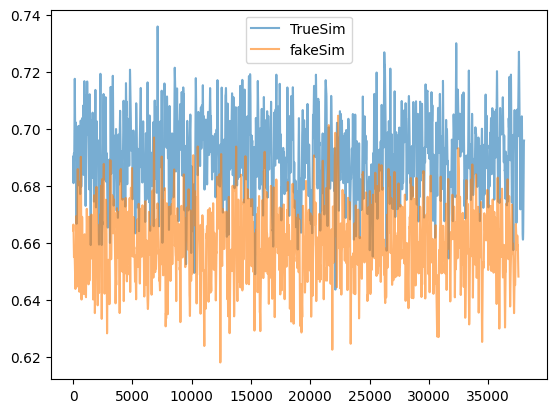

In [126]:
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

plt.plot(gaussian_filter(true_pairs, sigma=20), label="TrueSim", alpha=.6)
plt.plot(gaussian_filter(fake_pairs, sigma=20), label="fakeSim", alpha=.6)
plt.legend()

In [122]:
print(n_correct / len(open_dataset))

0.5479517307081613


In [123]:
print(f"Test set with {len(test_dataset)} samples of {len(set(test_dataset.labels))} classes.")
# print(f"Baseline model openset performance: {baseline_accuracy}")
print(f"Triplet model openset performance: {triplet_accuracy}")

NameError: name 'test_dataset' is not defined

TODO: Compare best model performances to majority classifier and specify that the bad model still has some knowledge. Also use random classifier